/var/folders/8_/lltwgz4x48ncx3q3k86fr_tm0000gq/T/ipykernel_94983/2337693144.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_loca

Loaded model weights


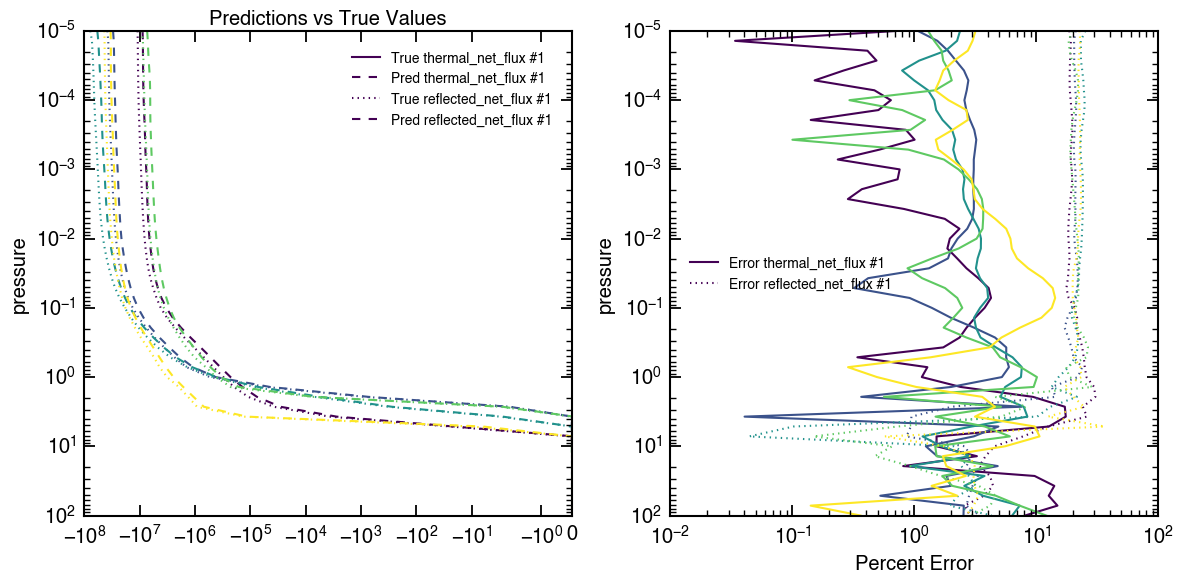

In [22]:
#!/usr/bin/env python3
"""
simple_plot.py - Minimal script to plot model predictions against true values.
"""

import sys
sys.path.append('../src')

import json
import json5
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import create_prediction_model
from normalizer import DataNormalizer

plt.style.use('science.mplstyle')

# Hard-coded paths
DATA_PATH = "../data/normalized_profiles"
METADATA_PATH = "../data/normalized_profiles/normalization_metadata.json"
MODEL_PATH = "../data/model/best_model.pt"
CONFIG_PATH = "../inputs/model_input_params.jsonc"

# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = json5.load(f)

# Get variable names from config
input_vars = config["input_variables"]
target_vars = config["target_variables"]
feature1, feature2 = target_vars[0], target_vars[1]  # Features to plot
coord_var = "pressure"  # Coordinate variable

# Load the model and its weights
checkpoint = torch.load(MODEL_PATH, map_location='cpu')
model = create_prediction_model(config)

try:
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    print("Loaded model weights")
except Exception as e:
    print(f"Error loading model: {e}")

model.eval()

# Load normalization metadata
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

# Get test files (skip the metadata file)
test_files = [f for f in Path(DATA_PATH).glob("*.json") if f.name != "normalization_metadata.json"][:5]
colors = plt.cm.viridis(np.linspace(0, 1, len(test_files)))

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=False)

for i, (file_path, color) in enumerate(zip(test_files, colors)):
    try:
        # Load the profile data
        with open(file_path, 'r') as f:
            profile = json.load(f)
        
        # Get coordinate values (pressure levels)
        coord_vals = profile.get(coord_var, [])
        if not isinstance(coord_vals, list):
            coord_vals = [coord_vals]
        seq_len = len(coord_vals)
        
        # Prepare inputs: simple dictionary with sequence and global features
        inputs = {}
        
        # Get the sequence type (just use the first one)
        seq_types = config.get("sequence_types", {"profile": []})
        seq_type = list(seq_types.keys())[0]
        seq_indices = seq_types[seq_type]
        
        # Process sequence data
        if seq_indices:
            seq_features = []
            for idx in seq_indices:
                val = profile.get(input_vars[idx], 0)
                if isinstance(val, list):
                    values = val[:seq_len] if len(val) >= seq_len else val + [val[-1]] * (seq_len - len(val))
                else:
                    values = [float(val)] * seq_len
                seq_features.append(torch.tensor(values, dtype=torch.float32))
            
            inputs[seq_type] = torch.stack(seq_features, dim=1).unsqueeze(0)
        
        # Process global features if any
        global_indices = config.get("global_feature_indices", [])
        if global_indices:
            global_values = []
            for idx in global_indices:
                val = profile.get(input_vars[idx], 0)
                val_float = float(val[0]) if isinstance(val, list) and val else float(val)
                global_values.append(val_float)
            inputs["global"] = torch.tensor(global_values, dtype=torch.float32).unsqueeze(0)
        
        # Run prediction
        with torch.no_grad():
            predictions = model(inputs)
            if predictions.dim() == 2:
                predictions = predictions.unsqueeze(1)
        
        # Process each target variable
        for j, feature in enumerate([feature1, feature2]):
            target_idx = target_vars.index(feature)
            
            # Get true values
            true_vals = profile.get(feature, [0] * seq_len)
            if not isinstance(true_vals, list):
                true_vals = [true_vals] * seq_len
            
            # Get predictions
            pred_vals = predictions[0, :seq_len, target_idx].cpu().numpy()
            
            # Denormalize values
            true_denorm = np.array(DataNormalizer.denormalize(true_vals, metadata, feature)).flatten()
            pred_denorm = np.array(DataNormalizer.denormalize(pred_vals, metadata, feature)).flatten()
            coord_denorm = np.array(DataNormalizer.denormalize(coord_vals, metadata, coord_var)).flatten()
            
            # Match lengths
            min_len = min(len(true_denorm), len(pred_denorm), len(coord_denorm))
            true_denorm = true_denorm[:min_len]
            pred_denorm = pred_denorm[:min_len]
            coord_denorm = coord_denorm[:min_len]
            
            # Calculate percent error
            epsilon = 1  # Small value to avoid division by zero
            error = 100 * np.abs(pred_denorm - true_denorm) / np.maximum(np.abs(true_denorm), epsilon)
            
            # Plot values
            linestyle = '-' if j == 0 else ':'
            label_suffix = feature1 if j == 0 else feature2
            
            # Plot predictions vs truth
            ax1.plot(true_denorm, coord_denorm, color=color, linestyle=linestyle,
                     label=f"True {label_suffix} #{i+1}" if i == 0 else None)
            ax1.plot(pred_denorm, coord_denorm, color=color, linestyle='--',
                     label=f"Pred {label_suffix} #{i+1}" if i == 0 else None)
            
            # Plot error
            ax2.plot(error, coord_denorm, color=color, linestyle=linestyle,
                     label=f"Error {label_suffix} #{i+1}" if i == 0 else None)
            
    except Exception as e:
        print(f"Error processing {file_path.name}: {e}")

# Configure plots
ax1.set_ylabel(coord_var)
ax1.set_title("Predictions vs True Values")
ax1.set_yscale('log')
ax1.set_xscale('symlog')
ax1.set_ylim(1e2, 1e-5)
ax1.set_xlim(-1e8, 0)
ax1.legend(loc='best', fontsize='small')

ax2.set_xlabel("Percent Error")
ax2.set_ylabel(coord_var)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(1e-2, 1e2)
ax2.set_ylim(1e2, 1e-5)
ax2.legend(loc='best', fontsize='small')

plt.tight_layout()
output_dir = Path("../plots")
output_dir.mkdir(exist_ok=True)
plt.savefig(output_dir / "simple_model_plot.png")
plt.show()